# EN3150 Assignment 03: Simple convolutional neural network to perform classification.

Done by:

- Alahakoon U.M.Y.B. (210027C)
- Dulnath
- Jayakumar W.S. (210236P)
- Ratnayake

Instructed by: Dr. Sampath K. Perera

In this assignemnt, our focus is to create a simple image classifier using convolutional neural networks (CNN).

### Import necessary packages

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
print(device)

cuda


In [3]:
full_dataset = ImageFolder(root='Realwaste', transform=transforms.Compose([
    transforms.Resize((131, 131)),
    transforms.ToTensor()
]))
print(full_dataset.classes)
print(len(full_dataset))

['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
4752


In [4]:
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [int(len(full_dataset) * 0.6), 
                                                                                          int(len(full_dataset) * 0.2), 
                                                                                          len(full_dataset) - int(len(full_dataset) * 0.6) - int(len(full_dataset) * 0.2)])
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

test_targets = [test_dataset.dataset.targets[i] for i in test_dataset.indices]

2851
950
951


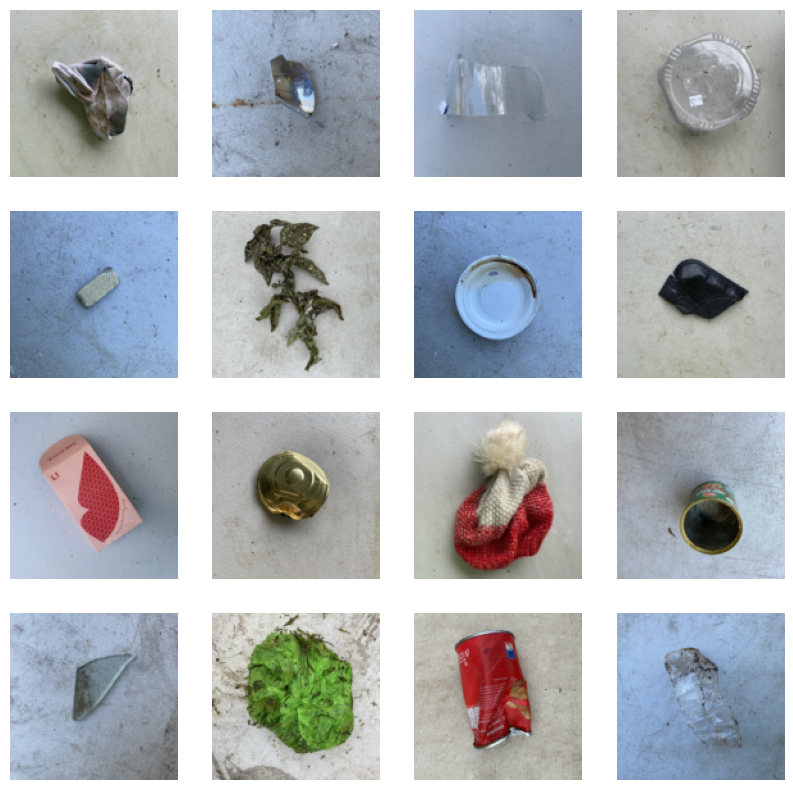

In [15]:
random_indices = random.sample(range(len(train_dataset)), 16)
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
for i, idx in enumerate(random_indices):
    img = train_dataset[idx][0]
    ax = axs[i//4, i%4]
    ax.imshow(img.permute(1, 2, 0))
    ax.axis("off")
plt.show()

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Linear(64 * 14 * 14, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 9)
        )
        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

In [6]:
def train(model:nn.Module,
          trainloader:torch.utils.data.DataLoader,
          testloader:torch.utils.data.DataLoader,
          iterations:int,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          device: torch.device,
          to_print: bool) -> tuple:
    train_accuracy_hist = [ ]
    test_accuracy_hist = [ ]
    train_loss_hist = [ ]
    test_loss_hist = [ ]
    for t in range(iterations):
        model.train()
        accuracy = 0
        running_loss = 0.0
        for _, data in enumerate(trainloader, 0):
            inputs, labels = data
            x_train, y_train = inputs.to(device), labels.to(device)
            y_pred = model(x_train)
            loss_val = loss_fn(y_pred, y_train)
            running_loss += loss_val.item()
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            _, predicted = torch.max(y_pred, 1)
            accuracy += (predicted == y_train).sum().item()
        train_accuracy_hist.append(accuracy / len(trainloader.dataset))
        train_loss_hist.append(running_loss / len(trainloader))
        model.eval()
        with torch.inference_mode():
            accuracy = 0
            running_loss = 0.0
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                x_test, y_test = inputs.to(device), labels.to(device)
                y_pred = model(x_test)
                loss_val = loss_fn(y_pred, y_test)
                running_loss += loss_val.item()
                _, predicted = torch.max(y_pred, 1)
                accuracy += (predicted == y_test).sum().item()
            test_accuracy_hist.append(accuracy / len(testloader.dataset))
            test_loss_hist.append(running_loss / len(testloader))
        if to_print:
            print(f"Epoch {t + 1} / {iterations}, Train Loss: {train_loss_hist[-1]}, Test Loss: {test_loss_hist[-1]}, Train Accuracy: {train_accuracy_hist[-1]}, Test Accuracy: {test_accuracy_hist[-1]}")
    return train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist

In [7]:
def calculate_accuracy(model: nn.Module, dataloader: torch.utils.data.DataLoader) -> float:
    correct = 0
    total = 0
    predictions = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            x, y = inputs.to(device), labels.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)
            predictions.append(predicted)
            total += y.size(0)
            correct += (predicted == y).sum().item()
    return 100 * correct / total, torch.cat(predictions)

In [6]:
model = cnn_model().to(device)
print(summary(cnn_model(), input_size=(BATCH_SIZE, 3, 131, 131)))

Layer (type:depth-idx)                   Output Shape              Param #
cnn_model                                [32, 9]                   --
├─Sequential: 1-1                        [32, 16, 64, 64]          --
│    └─Conv2d: 2-1                       [32, 16, 129, 129]        448
│    └─ReLU: 2-2                         [32, 16, 129, 129]        --
│    └─MaxPool2d: 2-3                    [32, 16, 64, 64]          --
├─Sequential: 1-2                        [32, 32, 31, 31]          --
│    └─Conv2d: 2-4                       [32, 32, 62, 62]          4,640
│    └─ReLU: 2-5                         [32, 32, 62, 62]          --
│    └─MaxPool2d: 2-6                    [32, 32, 31, 31]          --
├─Sequential: 1-3                        [32, 64, 14, 14]          --
│    └─Conv2d: 2-7                       [32, 64, 29, 29]          18,496
│    └─ReLU: 2-8                         [32, 64, 29, 29]          --
│    └─MaxPool2d: 2-9                    [32, 64, 14, 14]          --
├─Flatt

In [11]:
iterations = 20
loss = nn.CrossEntropyLoss()
model = cnn_model().to(device) # This is used to reset the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 2.162530371877882, Test Loss: 2.101095167795817, Train Accuracy: 0.18098912662223782, Test Accuracy: 0.2031578947368421
Epoch 2 / 20, Train Loss: 2.102142181661394, Test Loss: 2.0140013376871746, Train Accuracy: 0.2304454577341284, Test Accuracy: 0.24421052631578946
Epoch 3 / 20, Train Loss: 2.018643301063114, Test Loss: 1.8748780965805054, Train Accuracy: 0.25429673798667135, Test Accuracy: 0.3021052631578947
Epoch 4 / 20, Train Loss: 1.92974927160475, Test Loss: 1.7783446431159973, Train Accuracy: 0.284461592423711, Test Accuracy: 0.3526315789473684
Epoch 5 / 20, Train Loss: 1.8162226782904731, Test Loss: 1.7980563084284464, Train Accuracy: 0.3293581199579095, Test Accuracy: 0.3547368421052632
Epoch 6 / 20, Train Loss: 1.7602897432115343, Test Loss: 1.6379841605822245, Train Accuracy: 0.37144861452122063, Test Accuracy: 0.42736842105263156
Epoch 7 / 20, Train Loss: 1.683394686381022, Test Loss: 1.530283558368683, Train Accuracy: 0.3861802876183795, Test Accu

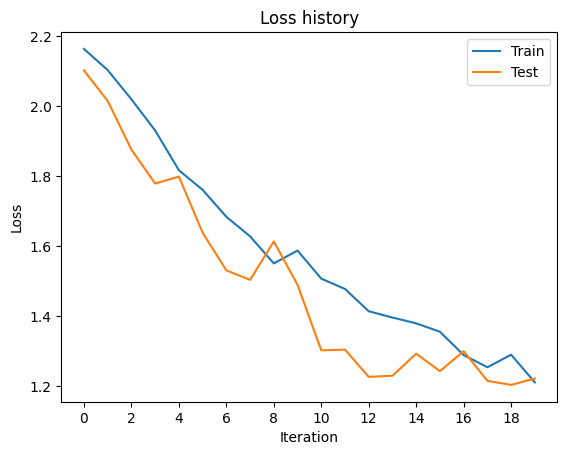

In [12]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

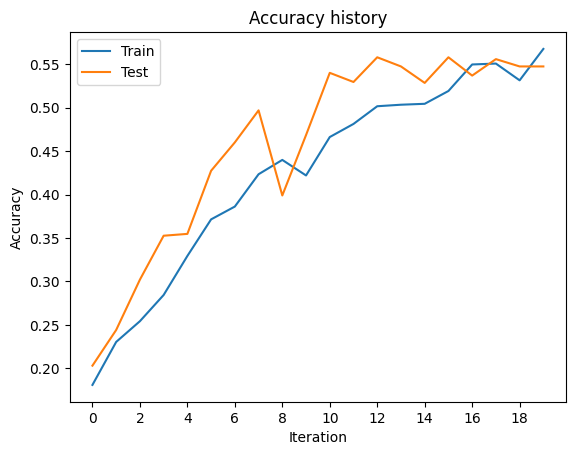

In [13]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 54.7844374342797%


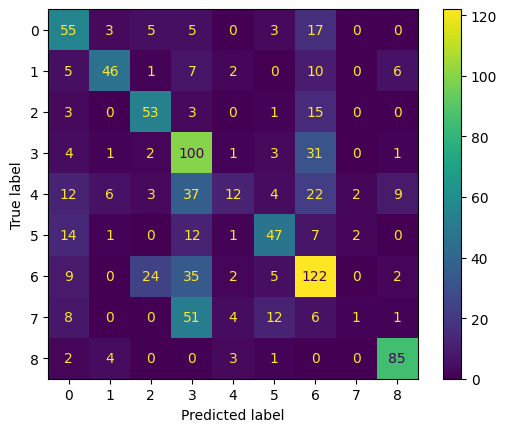

In [14]:
test_accuracy, test_predictions = calculate_accuracy(model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [15]:
train_accuracy,_ = calculate_accuracy(model, train_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 63.98%
Test accuracy: 54.78%


In [16]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
iterations = 20
train_accuracy_history_lr = [ ]
test_accuracy_history_lr = [ ]
loss = nn.CrossEntropyLoss()
for learning_rate in learning_rates:
    model = cnn_model().to(device) # This is used to reset the model
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)
    train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(model, train_dataloader, test_dataloader, iterations, optimizer, loss, device, False)
    train_accuracy_history_lr.append(train_accuracy_hist[-1])
    test_accuracy_history_lr.append(test_accuracy_hist[-1])
    print(f"Learning Rate: {learning_rate}, Train Accuracy: {train_accuracy}, Test Accuracy: {test_accuracy}")

Learning Rate: 0.0001, Train Accuracy: 63.977551736232904, Test Accuracy: 54.7844374342797
Learning Rate: 0.001, Train Accuracy: 63.977551736232904, Test Accuracy: 54.7844374342797
Learning Rate: 0.01, Train Accuracy: 63.977551736232904, Test Accuracy: 54.7844374342797
Learning Rate: 0.1, Train Accuracy: 63.977551736232904, Test Accuracy: 54.7844374342797


## Using a SOTA model for image classification as feature extractors

### Resnet-18

In [20]:
resnet_model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1').to(device) # These are the default weights
print(summary(resnet_model, input_size=(BATCH_SIZE, 3, 524, 524), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 524, 524]         [32, 1000]                --                        True
├─Conv2d: 1-1                            [32, 3, 524, 524]         [32, 64, 262, 262]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 262, 262]        [32, 64, 262, 262]        128                       True
├─ReLU: 1-3                              [32, 64, 262, 262]        [32, 64, 262, 262]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 262, 262]        [32, 64, 131, 131]        --                        --
├─Sequential: 1-5                        [32, 64, 131, 131]        [32, 64, 131, 131]        --                        True
│    └─BasicBlock: 2-1                   [32, 64, 131, 131]        [32, 64, 131, 131]        --                        True
│    │ 

In [21]:
for param in resnet_model.parameters():
    param.requires_grad = False

resnet_model.fc = nn.Linear(in_features=512, out_features=9, bias=True).to(device)
print(resnet_model.fc)

Linear(in_features=512, out_features=9, bias=True)


In [22]:
print(summary(resnet_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 131, 131]         [32, 9]                   --                        Partial
├─Conv2d: 1-1                            [32, 3, 131, 131]         [32, 64, 66, 66]          (9,408)                   False
├─BatchNorm2d: 1-2                       [32, 64, 66, 66]          [32, 64, 66, 66]          (128)                     False
├─ReLU: 1-3                              [32, 64, 66, 66]          [32, 64, 66, 66]          --                        --
├─MaxPool2d: 1-4                         [32, 64, 66, 66]          [32, 64, 33, 33]          --                        --
├─Sequential: 1-5                        [32, 64, 33, 33]          [32, 64, 33, 33]          --                        False
│    └─BasicBlock: 2-1                   [32, 64, 33, 33]          [32, 64, 33, 33]          --                        False


In [23]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr = 0.001, weight_decay = 0.001)
iterations = 20

In [24]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(resnet_model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 1.5958216534720526, Test Loss: 1.1856560826301574, Train Accuracy: 0.4566818660119256, Test Accuracy: 0.6210526315789474
Epoch 2 / 20, Train Loss: 1.077919477886624, Test Loss: 1.0289047578970592, Train Accuracy: 0.6527534198526833, Test Accuracy: 0.6631578947368421
Epoch 3 / 20, Train Loss: 0.9449471947219636, Test Loss: 0.9449241518974304, Train Accuracy: 0.6948439144159944, Test Accuracy: 0.6926315789473684
Epoch 4 / 20, Train Loss: 0.8515691565142738, Test Loss: 0.9196032027403513, Train Accuracy: 0.7229042441248684, Test Accuracy: 0.7042105263157895
Epoch 5 / 20, Train Loss: 0.7938683576054043, Test Loss: 0.8699560264746348, Train Accuracy: 0.7471062784987723, Test Accuracy: 0.7052631578947368
Epoch 6 / 20, Train Loss: 0.7616998086373011, Test Loss: 0.8607838392257691, Train Accuracy: 0.7428972290424413, Test Accuracy: 0.7126315789473684
Epoch 7 / 20, Train Loss: 0.7456186049514346, Test Loss: 0.882880014181137, Train Accuracy: 0.748860049105577, Test Acc

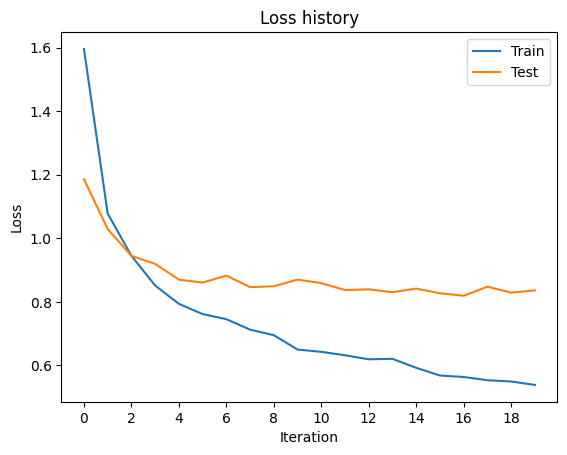

In [25]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

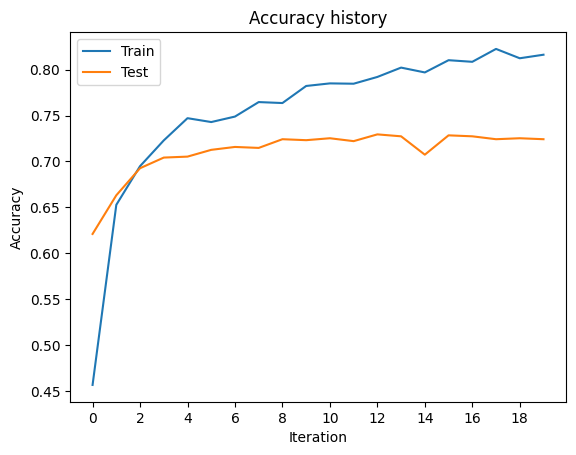

In [26]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 71.60883280757098%


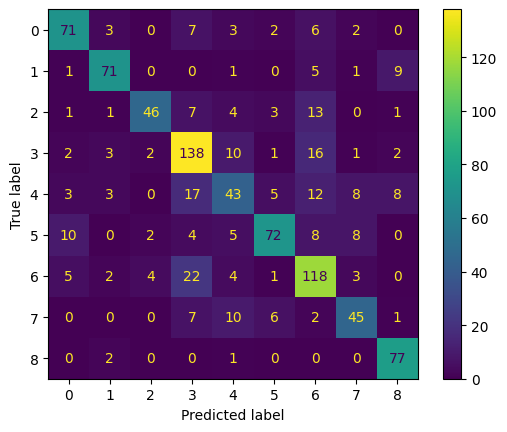

In [27]:
test_accuracy, test_predictions = calculate_accuracy(resnet_model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [28]:
train_accuracy,_ = calculate_accuracy(resnet_model, train_dataloader)
test_accuracy,_ = calculate_accuracy(resnet_model, test_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 85.20%
Test accuracy: 71.61%


### VGG-16

In [29]:
vgg_model = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights).to(device) # These are the default weights
print(summary(vgg_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
VGG                                      [32, 3, 131, 131]         [32, 1000]                --                        True
├─Sequential: 1-1                        [32, 3, 131, 131]         [32, 512, 4, 4]           --                        True
│    └─Conv2d: 2-1                       [32, 3, 131, 131]         [32, 64, 131, 131]        1,792                     True
│    └─ReLU: 2-2                         [32, 64, 131, 131]        [32, 64, 131, 131]        --                        --
│    └─Conv2d: 2-3                       [32, 64, 131, 131]        [32, 64, 131, 131]        36,928                    True
│    └─ReLU: 2-4                         [32, 64, 131, 131]        [32, 64, 131, 131]        --                        --
│    └─MaxPool2d: 2-5                    [32, 64, 131, 131]        [32, 64, 65, 65]          --                        --
│    └─Co

In [30]:
for param in vgg_model.parameters():
    param.requires_grad = False

vgg_model.classifier[6] = nn.Linear(in_features=4096, out_features=9, bias=True).to(device)


In [31]:
print(summary(vgg_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
VGG                                      [32, 3, 131, 131]         [32, 9]                   --                        Partial
├─Sequential: 1-1                        [32, 3, 131, 131]         [32, 512, 4, 4]           --                        False
│    └─Conv2d: 2-1                       [32, 3, 131, 131]         [32, 64, 131, 131]        (1,792)                   False
│    └─ReLU: 2-2                         [32, 64, 131, 131]        [32, 64, 131, 131]        --                        --
│    └─Conv2d: 2-3                       [32, 64, 131, 131]        [32, 64, 131, 131]        (36,928)                  False
│    └─ReLU: 2-4                         [32, 64, 131, 131]        [32, 64, 131, 131]        --                        --
│    └─MaxPool2d: 2-5                    [32, 64, 131, 131]        [32, 64, 65, 65]          --                        --
│  

In [32]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr = 0.001, weight_decay = 0.001)
iterations = 20

In [33]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(vgg_model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 1.2831665370199414, Test Loss: 1.0290347615877786, Train Accuracy: 0.5380568221676605, Test Accuracy: 0.6494736842105263
Epoch 2 / 20, Train Loss: 0.9634664065308041, Test Loss: 0.9767005920410157, Train Accuracy: 0.6506488951245177, Test Accuracy: 0.6610526315789473
Epoch 3 / 20, Train Loss: 0.8648189557923212, Test Loss: 0.9367201129595438, Train Accuracy: 0.692037881445107, Test Accuracy: 0.6789473684210526
Epoch 4 / 20, Train Loss: 0.82105293571949, Test Loss: 0.9171150336662929, Train Accuracy: 0.7169414240617328, Test Accuracy: 0.6978947368421052
Epoch 5 / 20, Train Loss: 0.7579409152269363, Test Loss: 0.9096975356340409, Train Accuracy: 0.7337776218870572, Test Accuracy: 0.6926315789473684
Epoch 6 / 20, Train Loss: 0.769290346900622, Test Loss: 0.9208685686190923, Train Accuracy: 0.7271132935811996, Test Accuracy: 0.6936842105263158
Epoch 7 / 20, Train Loss: 0.7273928357495202, Test Loss: 0.9046319156885148, Train Accuracy: 0.7464047702560505, Test Accu

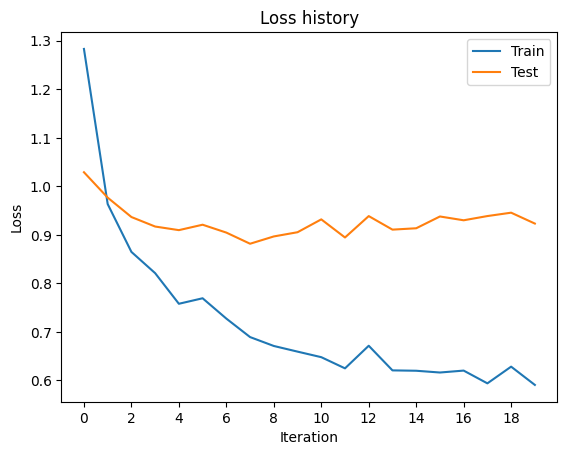

In [34]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

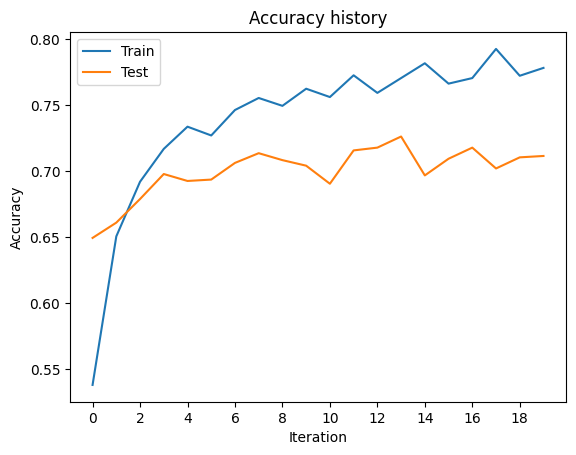

In [35]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 70.66246056782335%


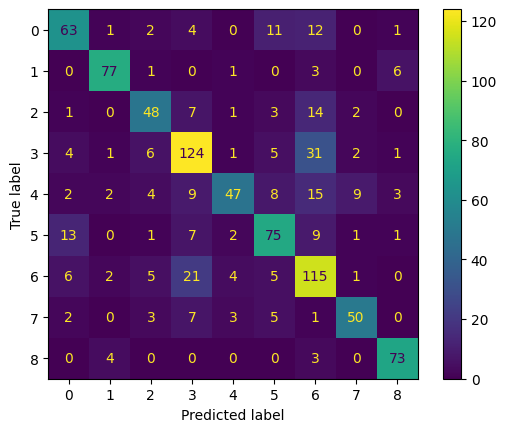

In [36]:
test_accuracy, test_predictions = calculate_accuracy(vgg_model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [37]:
train_accuracy,_ = calculate_accuracy(vgg_model, train_dataloader)
test_accuracy,_ = calculate_accuracy(vgg_model, test_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 92.70%
Test accuracy: 70.66%


### Resnet-152

In [41]:
resnet152_model = torchvision.models.resnet152(weights = torchvision.models.ResNet152_Weights).to(device) # These are the default weights
print(summary(resnet152_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 131, 131]         [32, 1000]                --                        True
├─Conv2d: 1-1                            [32, 3, 131, 131]         [32, 64, 66, 66]          9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 66, 66]          [32, 64, 66, 66]          128                       True
├─ReLU: 1-3                              [32, 64, 66, 66]          [32, 64, 66, 66]          --                        --
├─MaxPool2d: 1-4                         [32, 64, 66, 66]          [32, 64, 33, 33]          --                        --
├─Sequential: 1-5                        [32, 64, 33, 33]          [32, 256, 33, 33]         --                        True
│    └─Bottleneck: 2-1                   [32, 64, 33, 33]          [32, 256, 33, 33]         --                        True
│    │ 

In [42]:
for param in resnet152_model.parameters():
    param.requires_grad = False

resnet152_model.fc = nn.Linear(in_features=2048, out_features=9, bias=True).to(device)


In [43]:
print(summary(resnet152_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 131, 131]         [32, 9]                   --                        Partial
├─Conv2d: 1-1                            [32, 3, 131, 131]         [32, 64, 66, 66]          (9,408)                   False
├─BatchNorm2d: 1-2                       [32, 64, 66, 66]          [32, 64, 66, 66]          (128)                     False
├─ReLU: 1-3                              [32, 64, 66, 66]          [32, 64, 66, 66]          --                        --
├─MaxPool2d: 1-4                         [32, 64, 66, 66]          [32, 64, 33, 33]          --                        --
├─Sequential: 1-5                        [32, 64, 33, 33]          [32, 256, 33, 33]         --                        False
│    └─Bottleneck: 2-1                   [32, 64, 33, 33]          [32, 256, 33, 33]         --                        False


In [44]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet152_model.parameters(), lr = 0.001, weight_decay = 0.001)
iterations = 20

In [45]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(resnet152_model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 1.3338925427860684, Test Loss: 0.9664728065331777, Train Accuracy: 0.5408628551385479, Test Accuracy: 0.6863157894736842
Epoch 2 / 20, Train Loss: 0.9061058925257789, Test Loss: 0.8708551665147145, Train Accuracy: 0.6951946685373553, Test Accuracy: 0.7315789473684211
Epoch 3 / 20, Train Loss: 0.7869528734021717, Test Loss: 0.8439725359280904, Train Accuracy: 0.7309715889161698, Test Accuracy: 0.7221052631578947
Epoch 4 / 20, Train Loss: 0.717707723710272, Test Loss: 0.7990237514177958, Train Accuracy: 0.7593826727464048, Test Accuracy: 0.7410526315789474
Epoch 5 / 20, Train Loss: 0.6808735046121809, Test Loss: 0.7876192341248195, Train Accuracy: 0.7730620834794809, Test Accuracy: 0.7442105263157894
Epoch 6 / 20, Train Loss: 0.6169247604078717, Test Loss: 0.8242895931005478, Train Accuracy: 0.8004209049456331, Test Accuracy: 0.7410526315789474
Epoch 7 / 20, Train Loss: 0.6001372694969177, Test Loss: 0.7996866345405579, Train Accuracy: 0.791301297790249, Test Ac

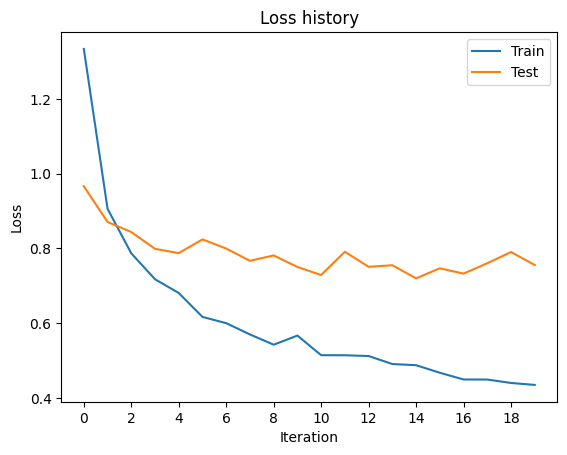

In [46]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

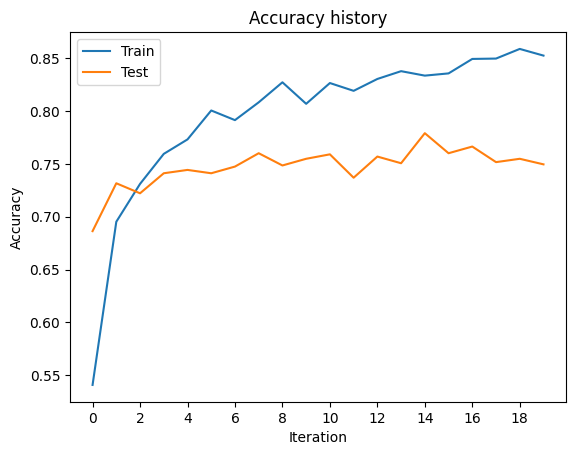

In [47]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 72.34490010515248%


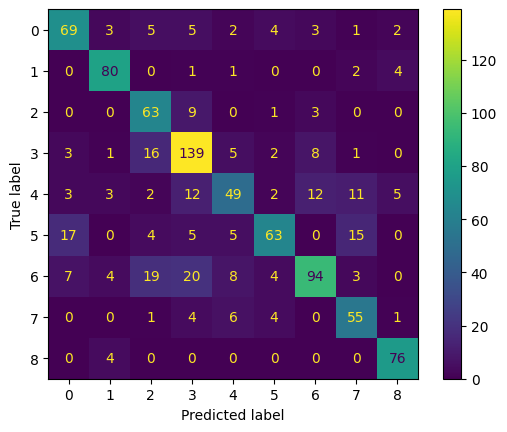

In [48]:
test_accuracy, test_predictions = calculate_accuracy(resnet152_model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [49]:
train_accuracy,_ = calculate_accuracy(resnet152_model, train_dataloader)
test_accuracy,_ = calculate_accuracy(resnet152_model, test_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 90.11%
Test accuracy: 72.34%


### Vision Transformer

In [ ]:
full_dataset_transformer = ImageFolder(root='Realwaste', transform=transforms.Compose([
    transforms.Resize((224, 224)), # Vision transformer requires this size 
    transforms.ToTensor()
]))
print(full_dataset.classes)
print(len(full_dataset))

['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
4752


In [ ]:
train_dataset_transformer, valid_dataset_transformer, test_dataset_transformer = torch.utils.data.random_split(full_dataset, [int(len(full_dataset_transformer) * 0.6), 
                                                                                          int(len(full_dataset_transformer) * 0.2), 
                                                                                          len(full_dataset_transformer) - int(len(full_dataset_transformer) * 0.6) - int(len(full_dataset_transformer) * 0.2)])
print(len(train_dataset_transformer))
print(len(valid_dataset_transformer))
print(len(test_dataset_transformer))

test_targets = [test_dataset_transformer.dataset.targets[i] for i in test_dataset.indices]

2851
950
951


In [ ]:
train_dataloader_transformer = DataLoader(train_dataset_transformer, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader_transformer = DataLoader(valid_dataset_transformer, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader_transformer = DataLoader(test_dataset_transformer, batch_size=BATCH_SIZE, shuffle=False)

In [29]:
ViT_model = torchvision.models.vit_l_32(weights = torchvision.models.ViT_L_32_Weights.DEFAULT).to(device) # These are the default weights
print(summary(ViT_model, input_size=(BATCH_SIZE, 3, 224, 224), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                                  [32, 3, 224, 224]         [32, 1000]                1,024                     True
├─Conv2d: 1-1                                      [32, 3, 224, 224]         [32, 1024, 7, 7]          3,146,752                 True
├─Encoder: 1-2                                     [32, 50, 1024]            [32, 50, 1024]            51,200                    True
│    └─Dropout: 2-1                                [32, 50, 1024]            [32, 50, 1024]            --                        --
│    └─Sequential: 2-2                             [32, 50, 1024]            [32, 50, 1024]            --                        True
│    │    └─EncoderBlock: 3-1                      [32, 50, 1024]            [32, 50, 1024]            12,596,224                True
│    │    └─EncoderBlock: 3-2                      [32, 50,

In [30]:
for param in ViT_model.parameters():
    param.requires_grad = False

ViT_model.heads = nn.Sequential(nn.Linear(in_features=1024, out_features=9, bias=True).to(device))

In [31]:
print(summary(ViT_model, input_size=(BATCH_SIZE, 3, 224, 224), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                                  [32, 3, 224, 224]         [32, 9]                   1,024                     Partial
├─Conv2d: 1-1                                      [32, 3, 224, 224]         [32, 1024, 7, 7]          (3,146,752)               False
├─Encoder: 1-2                                     [32, 50, 1024]            [32, 50, 1024]            51,200                    False
│    └─Dropout: 2-1                                [32, 50, 1024]            [32, 50, 1024]            --                        --
│    └─Sequential: 2-2                             [32, 50, 1024]            [32, 50, 1024]            --                        False
│    │    └─EncoderBlock: 3-1                      [32, 50, 1024]            [32, 50, 1024]            (12,596,224)              False
│    │    └─EncoderBlock: 3-2                      [

In [33]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ViT_model.parameters(), lr = 0.001, weight_decay = 0.001)
iterations = 20

In [34]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(ViT_model, train_dataloader_transformer, valid_dataloader_transformer, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 1.2647353970342212, Test Loss: 0.9151665687561035, Train Accuracy: 0.5738337425464749, Test Accuracy: 0.7115789473684211
Epoch 2 / 20, Train Loss: 0.7507208238045374, Test Loss: 0.7492628137270609, Train Accuracy: 0.7737635917222028, Test Accuracy: 0.7642105263157895
Epoch 3 / 20, Train Loss: 0.6067261040210724, Test Loss: 0.6854480803012848, Train Accuracy: 0.8046299544019643, Test Accuracy: 0.7757894736842105
Epoch 4 / 20, Train Loss: 0.5191022550066312, Test Loss: 0.6641100188096364, Train Accuracy: 0.8418098912662224, Test Accuracy: 0.7736842105263158
Epoch 5 / 20, Train Loss: 0.4597794888334142, Test Loss: 0.6315002342065176, Train Accuracy: 0.8618028761837951, Test Accuracy: 0.7842105263157895
Epoch 6 / 20, Train Loss: 0.41665073103374906, Test Loss: 0.6117466489473978, Train Accuracy: 0.8782883198877587, Test Accuracy: 0.7842105263157895
Epoch 7 / 20, Train Loss: 0.3813884960280524, Test Loss: 0.6082738916079203, Train Accuracy: 0.8993335671694143, Test

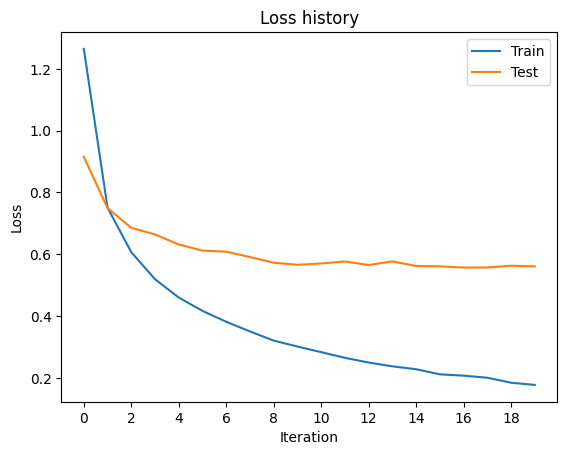

In [35]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

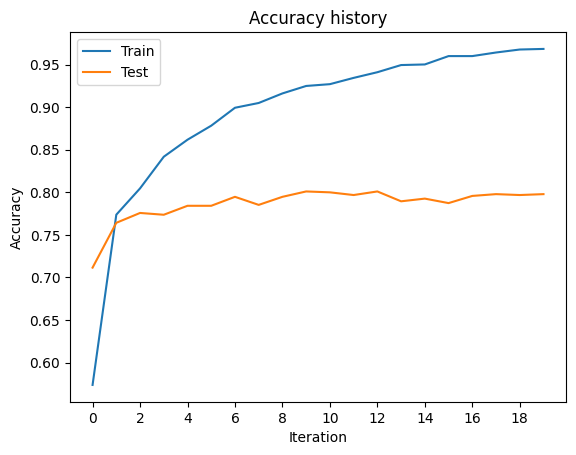

In [36]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 79.7055730809674%


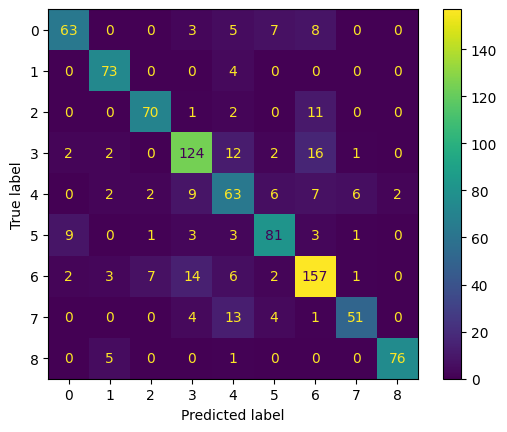

In [ ]:
test_accuracy, test_predictions = calculate_accuracy(ViT_model, test_dataloader_transformer)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [ ]:
train_accuracy,_ = calculate_accuracy(ViT_model, train_dataloader_transformer)
test_accuracy,_ = calculate_accuracy(ViT_model, test_dataloader_transformer)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 97.83%
Test accuracy: 79.71%


## Using a SOTA model for image classification finetuning

### Resnet-18

In [43]:
resnet_model = torchvision.models.resnet18(weights = 'IMAGENET1K_V1').to(device) # These are the default weights
print(summary(resnet_model, input_size=(BATCH_SIZE, 3, 524, 524), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 524, 524]         [32, 1000]                --                        True
├─Conv2d: 1-1                            [32, 3, 524, 524]         [32, 64, 262, 262]        9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 262, 262]        [32, 64, 262, 262]        128                       True
├─ReLU: 1-3                              [32, 64, 262, 262]        [32, 64, 262, 262]        --                        --
├─MaxPool2d: 1-4                         [32, 64, 262, 262]        [32, 64, 131, 131]        --                        --
├─Sequential: 1-5                        [32, 64, 131, 131]        [32, 64, 131, 131]        --                        True
│    └─BasicBlock: 2-1                   [32, 64, 131, 131]        [32, 64, 131, 131]        --                        True
│    │ 

In [44]:
resnet_model.fc = nn.Linear(in_features=512, out_features=9, bias=True).to(device)
print(resnet_model.fc)

Linear(in_features=512, out_features=9, bias=True)


In [45]:
print(summary(resnet_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 131, 131]         [32, 9]                   --                        True
├─Conv2d: 1-1                            [32, 3, 131, 131]         [32, 64, 66, 66]          9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 66, 66]          [32, 64, 66, 66]          128                       True
├─ReLU: 1-3                              [32, 64, 66, 66]          [32, 64, 66, 66]          --                        --
├─MaxPool2d: 1-4                         [32, 64, 66, 66]          [32, 64, 33, 33]          --                        --
├─Sequential: 1-5                        [32, 64, 33, 33]          [32, 64, 33, 33]          --                        True
│    └─BasicBlock: 2-1                   [32, 64, 33, 33]          [32, 64, 33, 33]          --                        True
│    │ 

In [46]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr = 0.001, weight_decay = 0.001)
iterations = 20

In [47]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(resnet_model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 1.2572589072916243, Test Loss: 1.2665621519088746, Train Accuracy: 0.5580498070852332, Test Accuracy: 0.5726315789473684
Epoch 2 / 20, Train Loss: 0.9704642706447177, Test Loss: 1.5256344477335613, Train Accuracy: 0.6478428621536303, Test Accuracy: 0.5178947368421053
Epoch 3 / 20, Train Loss: 1.0215985119342803, Test Loss: 2.1790023922920225, Train Accuracy: 0.6601192564012627, Test Accuracy: 0.48526315789473684
Epoch 4 / 20, Train Loss: 0.7443489909172059, Test Loss: 1.2106615881125131, Train Accuracy: 0.7471062784987723, Test Accuracy: 0.6
Epoch 5 / 20, Train Loss: 0.6428454435533948, Test Loss: 1.3087791085243226, Train Accuracy: 0.7804279200280604, Test Accuracy: 0.6189473684210526
Epoch 6 / 20, Train Loss: 0.5262662344508701, Test Loss: 1.2448945800463358, Train Accuracy: 0.8235706769554543, Test Accuracy: 0.6389473684210526
Epoch 7 / 20, Train Loss: 0.5615802865889338, Test Loss: 1.3070878724257151, Train Accuracy: 0.8067344791301297, Test Accuracy: 0.57

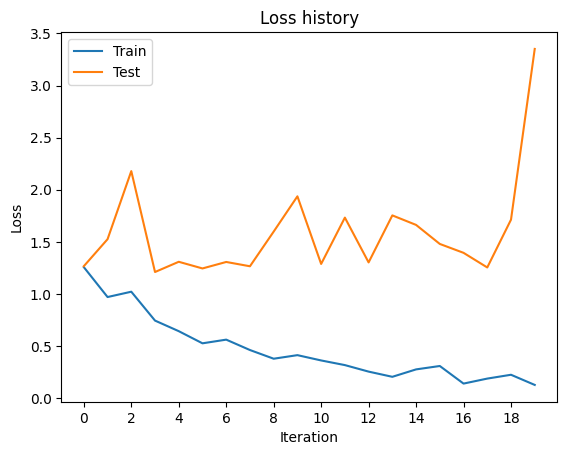

In [48]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

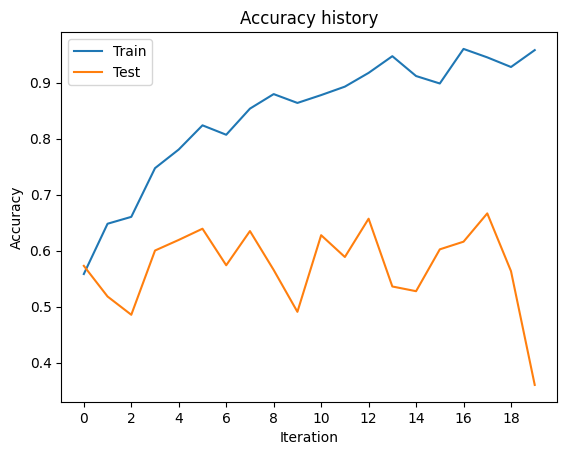

In [49]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 32.17665615141956%


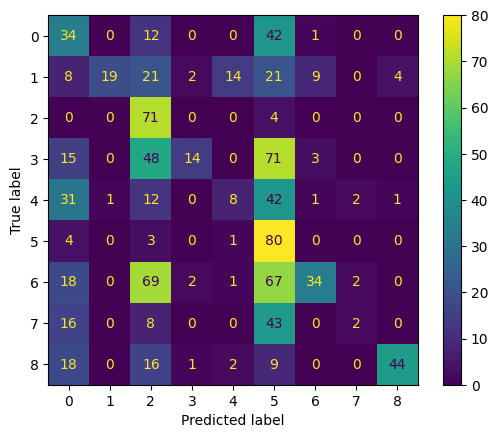

In [50]:
test_accuracy, test_predictions = calculate_accuracy(resnet_model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [51]:
train_accuracy,_ = calculate_accuracy(resnet_model, train_dataloader)
test_accuracy,_ = calculate_accuracy(resnet_model, test_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 51.42%
Test accuracy: 32.18%


### VGG-16

In [17]:
vgg_model = torchvision.models.vgg16(weights = torchvision.models.VGG16_Weights).to(device) # These are the default weights
print(summary(vgg_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
VGG                                      [32, 3, 131, 131]         [32, 1000]                --                        True
├─Sequential: 1-1                        [32, 3, 131, 131]         [32, 512, 4, 4]           --                        True
│    └─Conv2d: 2-1                       [32, 3, 131, 131]         [32, 64, 131, 131]        1,792                     True
│    └─ReLU: 2-2                         [32, 64, 131, 131]        [32, 64, 131, 131]        --                        --
│    └─Conv2d: 2-3                       [32, 64, 131, 131]        [32, 64, 131, 131]        36,928                    True
│    └─ReLU: 2-4                         [32, 64, 131, 131]        [32, 64, 131, 131]        --                        --
│    └─MaxPool2d: 2-5                    [32, 64, 131, 131]        [32, 64, 65, 65]          --                        --
│    └─Co

In [18]:
vgg_model.classifier[6] = nn.Linear(in_features=4096, out_features=9, bias=True).to(device)

In [19]:
print(summary(vgg_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
VGG                                      [32, 3, 131, 131]         [32, 9]                   --                        True
├─Sequential: 1-1                        [32, 3, 131, 131]         [32, 512, 4, 4]           --                        True
│    └─Conv2d: 2-1                       [32, 3, 131, 131]         [32, 64, 131, 131]        1,792                     True
│    └─ReLU: 2-2                         [32, 64, 131, 131]        [32, 64, 131, 131]        --                        --
│    └─Conv2d: 2-3                       [32, 64, 131, 131]        [32, 64, 131, 131]        36,928                    True
│    └─ReLU: 2-4                         [32, 64, 131, 131]        [32, 64, 131, 131]        --                        --
│    └─MaxPool2d: 2-5                    [32, 64, 131, 131]        [32, 64, 65, 65]          --                        --
│    └─Co

In [20]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg_model.parameters(), lr = 0.001, weight_decay = 0.001)
iterations = 20

In [21]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(vgg_model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 2.248660537931654, Test Loss: 2.062850844860077, Train Accuracy: 0.17222027358821465, Test Accuracy: 0.22631578947368422
Epoch 2 / 20, Train Loss: 1.9470009830262927, Test Loss: 1.8513290166854859, Train Accuracy: 0.26797614871974745, Test Accuracy: 0.25684210526315787
Epoch 3 / 20, Train Loss: 1.8087235755390592, Test Loss: 1.787570635477702, Train Accuracy: 0.31673097158891617, Test Accuracy: 0.3273684210526316
Epoch 4 / 20, Train Loss: 1.6324538853433397, Test Loss: 1.7193208813667298, Train Accuracy: 0.3952998947737636, Test Accuracy: 0.3778947368421053
Epoch 5 / 20, Train Loss: 1.550548379951053, Test Loss: 1.5139518618583678, Train Accuracy: 0.4279200280603297, Test Accuracy: 0.44842105263157894
Epoch 6 / 20, Train Loss: 1.5394657909870149, Test Loss: 1.6208757599194845, Train Accuracy: 0.4373903893370747, Test Accuracy: 0.4073684210526316
Epoch 7 / 20, Train Loss: 1.384140564997991, Test Loss: 1.6008416374524435, Train Accuracy: 0.4766748509294984, Test

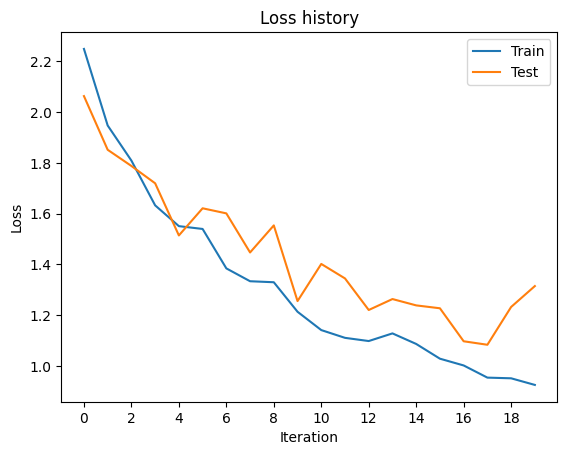

In [22]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

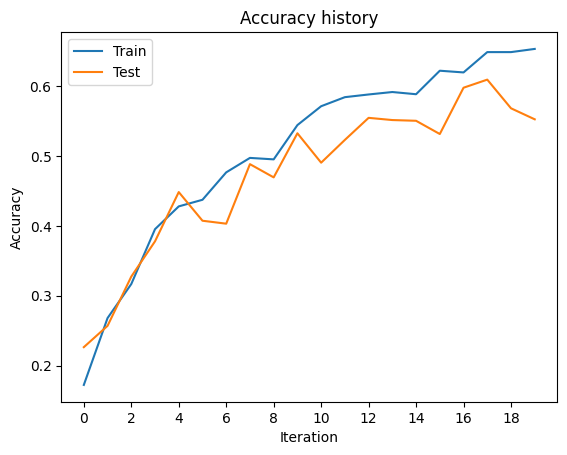

In [23]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 55.310199789695055%


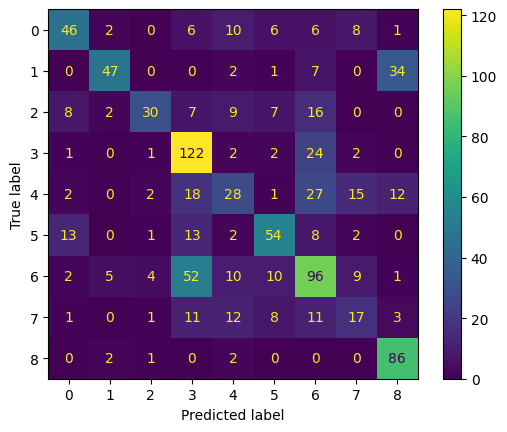

In [24]:
test_accuracy, test_predictions = calculate_accuracy(vgg_model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [25]:
train_accuracy,_ = calculate_accuracy(vgg_model, train_dataloader)
test_accuracy,_ = calculate_accuracy(vgg_model, test_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 65.87%
Test accuracy: 55.31%


### Resnet-152

In [8]:
resnet152_model = torchvision.models.resnet152(weights = torchvision.models.ResNet152_Weights).to(device) # These are the default weights
print(summary(resnet152_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

c:\Users\warre\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 131, 131]         [32, 1000]                --                        True
├─Conv2d: 1-1                            [32, 3, 131, 131]         [32, 64, 66, 66]          9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 66, 66]          [32, 64, 66, 66]          128                       True
├─ReLU: 1-3                              [32, 64, 66, 66]          [32, 64, 66, 66]          --                        --
├─MaxPool2d: 1-4                         [32, 64, 66, 66]          [32, 64, 33, 33]          --                        --
├─Sequential: 1-5                        [32, 64, 33, 33]          [32, 256, 33, 33]         --                        True
│    └─Bottleneck: 2-1                   [32, 64, 33, 33]          [32, 256, 33, 33]         --                        True
│    │ 

In [9]:
resnet152_model.fc = nn.Linear(in_features=2048, out_features=9, bias=True).to(device)

In [10]:
print(summary(resnet152_model, input_size=(BATCH_SIZE, 3, 131, 131), col_names=("input_size", "output_size", "num_params", "trainable")))

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [32, 3, 131, 131]         [32, 9]                   --                        True
├─Conv2d: 1-1                            [32, 3, 131, 131]         [32, 64, 66, 66]          9,408                     True
├─BatchNorm2d: 1-2                       [32, 64, 66, 66]          [32, 64, 66, 66]          128                       True
├─ReLU: 1-3                              [32, 64, 66, 66]          [32, 64, 66, 66]          --                        --
├─MaxPool2d: 1-4                         [32, 64, 66, 66]          [32, 64, 33, 33]          --                        --
├─Sequential: 1-5                        [32, 64, 33, 33]          [32, 256, 33, 33]         --                        True
│    └─Bottleneck: 2-1                   [32, 64, 33, 33]          [32, 256, 33, 33]         --                        True
│    │ 

In [11]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet152_model.parameters(), lr = 0.001, weight_decay = 0.001)
iterations = 20

In [12]:
train_accuracy_hist, test_accuracy_hist, train_loss_hist, test_loss_hist = train(resnet152_model, train_dataloader, valid_dataloader, iterations, optimizer, loss, device, True)

Epoch 1 / 20, Train Loss: 1.5011700318919288, Test Loss: 2.193083600203196, Train Accuracy: 0.4819361627499123, Test Accuracy: 0.3894736842105263
Epoch 2 / 20, Train Loss: 1.1870723207791647, Test Loss: 1.7280736009279887, Train Accuracy: 0.5773412837600842, Test Accuracy: 0.3989473684210526
Epoch 3 / 20, Train Loss: 1.0724744412634108, Test Loss: 1.4074331680933634, Train Accuracy: 0.6215363030515608, Test Accuracy: 0.5178947368421053
Epoch 4 / 20, Train Loss: 0.987827781173918, Test Loss: 1.5706135114034017, Train Accuracy: 0.6590669940371799, Test Accuracy: 0.45789473684210524
Epoch 5 / 20, Train Loss: 0.9162613782617781, Test Loss: 2.18433841864268, Train Accuracy: 0.6741494212556998, Test Accuracy: 0.4557894736842105
Epoch 6 / 20, Train Loss: 0.8935428539911906, Test Loss: 5.818377574284871, Train Accuracy: 0.6804629954401964, Test Accuracy: 0.14421052631578948
Epoch 7 / 20, Train Loss: 0.8322919554180569, Test Loss: 2.0825135986010235, Train Accuracy: 0.7190459487898982, Test Acc

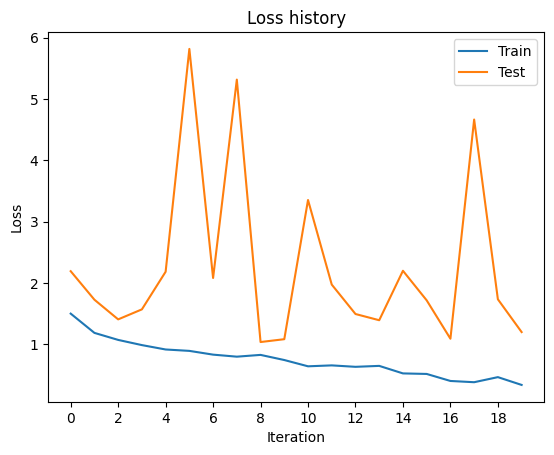

In [13]:
plt.plot(train_loss_hist, label='Train')
plt.plot(test_loss_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.xticks(range(0, iterations, 2))
plt.title('Loss history')
plt.legend()
plt.show()

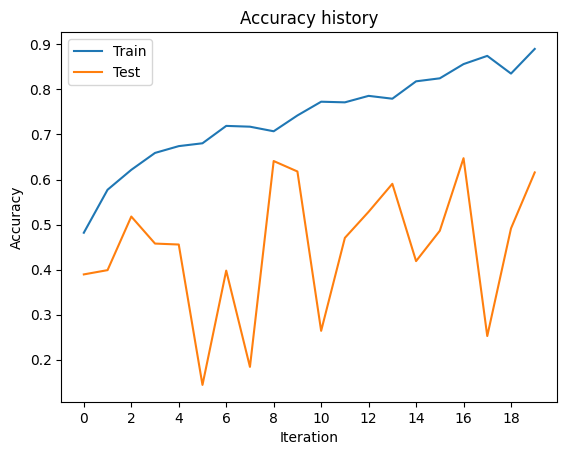

In [14]:
plt.plot(train_accuracy_hist, label='Train')
plt.plot(test_accuracy_hist, label='Test')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(0, iterations, 2))
plt.title('Accuracy history')
plt.legend()
plt.show()

Test accuracy: 59.936908517350155%


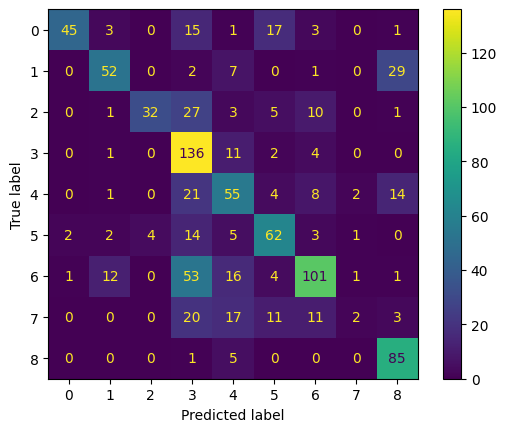

In [15]:
test_accuracy, test_predictions = calculate_accuracy(resnet152_model, test_dataloader)
print(f"Test accuracy: {test_accuracy}%")

cm = confusion_matrix(test_targets, test_predictions.cpu())
ConfusionMatrixDisplay(cm).plot()

In [16]:
train_accuracy,_ = calculate_accuracy(resnet152_model, train_dataloader)
test_accuracy,_ = calculate_accuracy(resnet152_model, test_dataloader)

print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Test accuracy: {test_accuracy:.2f}%")

Train accuracy: 79.24%
Test accuracy: 59.94%
